<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import pandas as pd
import json
import scripts.scrape_gdpr_fines

In [3]:
scripts.scrape_gdpr_fines.scrape_fines()

In [4]:
with open('data/scraped_fines.json', 'r', encoding='utf-8') as f:
    all_fines = json.load(f)

In [5]:
ungrouped = all_fines['allItems']
fines = pd.json_normalize(ungrouped)

In [6]:
text = pd.read_csv('data/gdpr_article_text.csv')

How are the fines distributed?

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
fines_nozero = fines.assign(price = lambda x: x.price+0.1)

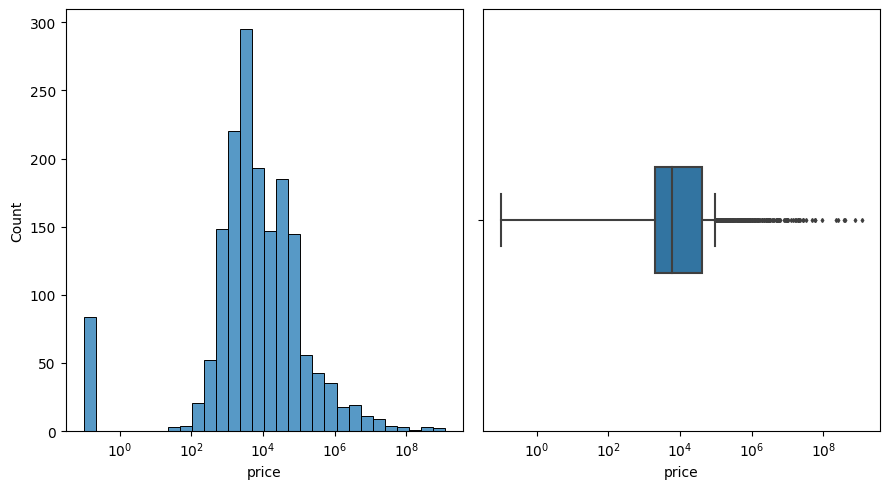

In [35]:
fig, ax = plt.subplots(1,2, figsize=(9, 5))
sns.histplot(data=fines_nozero, x="price", bins=30, log_scale=(True, False), ax=ax[0]);
sns.boxplot(data=fines_nozero, x="price", ax=ax[1], fliersize=2, width=0.25);

fig.axes[1].set_xscale('log')
fig.tight_layout()

gdpr_tidy <- gdpr_raw %>%
  transmute(id,
    price,
    country = name,
    article_violated,
    articles = str_extract_all(article_violated, "Art.[:digit:]+|Art. [:digit:]+")
  ) %>%
  mutate(total_articles = map_int(articles, length)) %>%
  unnest(articles) %>%
  add_count(articles) %>%
  filter(n > 10) %>%
  select(-n)

gdpr_tidy %>%
  mutate(
    articles = str_replace_all(articles, "Art. ", "Article "),
    articles = fct_reorder(articles, price)
  ) %>%
  ggplot(aes(articles, price + 1, color = articles, fill = articles)) +
  geom_boxplot(alpha = 0.2, outlier.colour = NA) +
  geom_quasirandom() +
  scale_y_log10(labels = scales::dollar_format(prefix = "€")) +
  labs(
    x = NULL, y = "GDPR fine (EUR)",
    title = "GDPR fines levied by article",
    subtitle = "For 250 violations in 25 countries"
  ) +
  theme(legend.position = "none")

In [70]:
fines_long = (
    fines
    .articleViolated.str.extractall(r'([Aa]rt. \d+(?=.*GDPR))')
    .reset_index()
    .rename(columns={'level_0':'id', 0:'article'})
    .assign(
        id = lambda x: x.id + 1,
        n_articles_violated = lambda x: (
            x
            .groupby('id')
            .match.transform('max')
            .astype('Int64') + 1
        ),
        article_number = lambda x: (
            x
            .article.str.extract(r'(\d+)')
            .astype('float')
            .astype('Int64')
        )
    )
    .merge(fines, how='right', left_on='id', right_on='id')
    .assign(date = lambda x: pd.to_datetime(x.date, format='%m/%d/%Y'))
    .loc[:, ['id', 'name', 'price', 'authority', 'date', 'controller','article',
             'article_number', 'n_articles_violated', 'type', 'summary']]
    .rename(columns={'price':'total_fine_euro', 'name': 'country'})
)

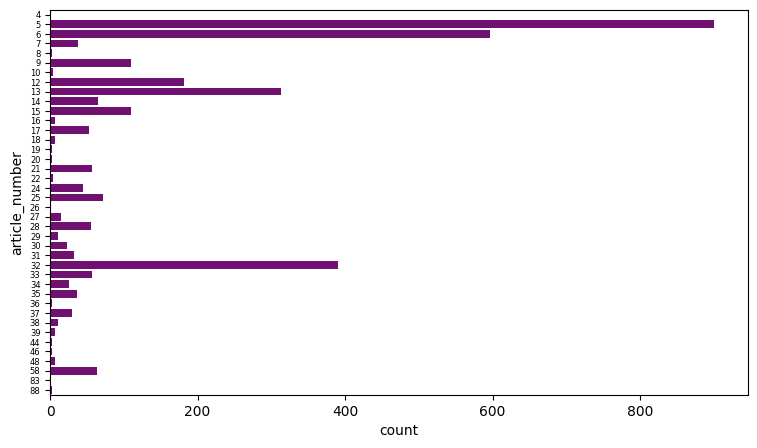

In [68]:
n_citations = (
    fines_long
    .value_counts('article_number')
    .reset_index()
    .sort_values('article_number')
)


fig, ax = plt.subplots(figsize = (9, 5))

ax = sns.barplot(y='article_number', x='count', data=n_citations, orient='h', color='purple')
ax.tick_params(axis='y', which='major', labelsize=6)

In [71]:
fines_long

,id,country,total_fine_euro,authority,date,controller,article,article_number,n_articles_violated,type,summary
0,1,Poland,9380,Polish National Personal Data Protection Offic...,2019-10-18,Polish Mayor,Art. 28,28,1,Non-compliance with lawful basis for data proc...,No data processing agreement has been conclude...
1,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 12,12,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
2,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 13,13,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
3,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 5,5,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
4,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 6,6,4,Information obligation non-compliance,A controller was sanctioned because he had unl...
...,...,...,...,...,...,...,...,...,...,...,...
3400,1699,Malta,2500,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 32,32,2,Failure to comply with data processing principles,The data controller had previously disclosed t...
3401,1700,Malta,20000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 13,13,2,Non-compliance with subjects' rights protectio...,The data controller had previously failed to c...
3402,1700,Malta,20000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 15,15,2,Non-compliance with subjects' rights protectio...,The data controller had previously failed to c...
3403,1701,Malta,4000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 13,13,2,Non-compliance with subjects' rights protectio...,The data controller had previously sent unsoli...



gdpr_tidy %>%
  mutate(
    articles = str_replace_all(articles, "Art. ", ""),
    articles = fct_reorder(articles, price)
  ) %>%
  ggplot(aes(articles, price + 1, color = articles, fill = articles)) +
  geom_boxplot(alpha = 0.2, outlier.colour = NA) +
  geom_quasirandom() +
  scale_y_log10(labels = scales::dollar_format(prefix = "€")) +
  labs(
    x = NULL, y = "GDPR fine (EUR)",
    title = "GDPR fines levied by article",
    subtitle = "For 250 violations in 25 countries"
  ) +
  theme(legend.position = "none")

In [12]:
plt.rcParams["figure.figsize"]=20,20

In [80]:
known_articles = (
    fines_long
    .query('total_fine_euro > 1')
    .sort_values('article_number')
    .dropna(subset='article_number')
)

[Text(0.5, 0, '')]

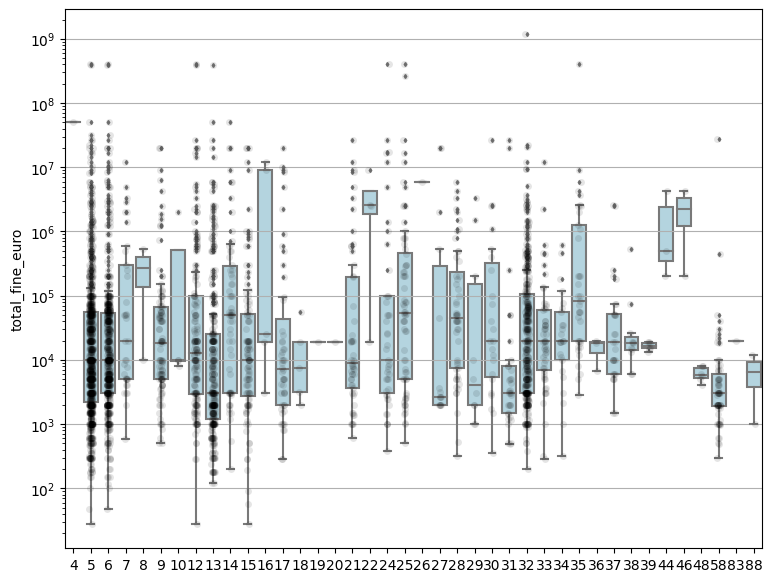

In [96]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_yscale("log")

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='black',
    jitter=0.1,
    alpha=0.1
)
    
sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='lightblue',
    fliersize=2
)

ax.yaxis.grid(True)
ax.set(xlabel="")

In [114]:
top_n_highest_fines = (
    known_articles
    .groupby('article_number')
    .agg({'total_fine_euro': 'sum'})
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
    .head(10)
)

only_top_n_highest_fines = (
    known_articles
    .loc[known_articles.article_number.isin(top_n_highest_fines.article_number.tolist())]
)

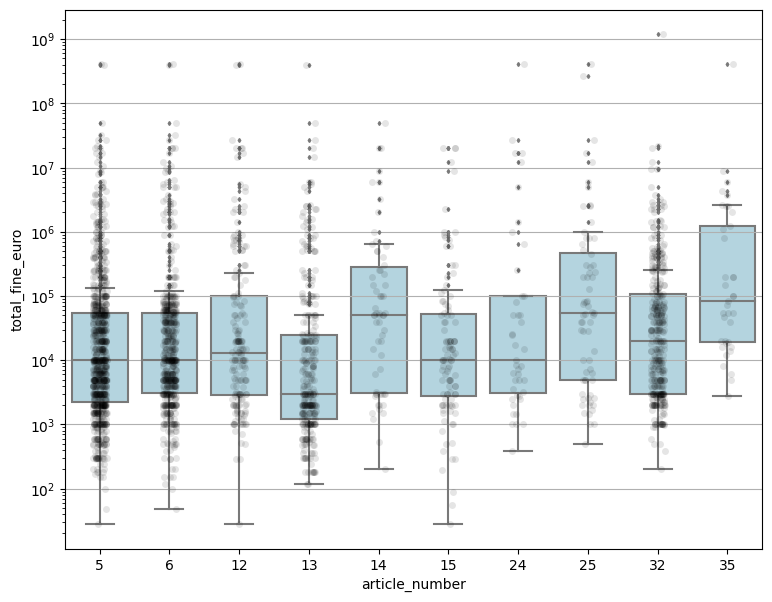

In [115]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_yscale("log")

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=only_top_n_highest_fines,
    color='black',
    jitter=0.1,
    alpha=0.1
)
    
sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=only_top_n_highest_fines,
    color='lightblue',
    fliersize=2
)

ax.yaxis.grid(True)

gdpr_violations <- gdpr_tidy %>%
  mutate(value = 1) %>%
  select(-article_violated) %>%
  pivot_wider(
    names_from = articles, values_from = value,
    values_fn = list(value = max), values_fill = list(value = 0)
  ) %>%
  janitor::clean_names()

gdpr_violations

In [119]:
only_top_n_highest_fines.head(2)

,id,country,total_fine_euro,authority,date,controller,article,article_number,n_articles_violated,type,summary
2616,1297,Romania,5000,Romanian National Supervisory Authority for Pe...,2023-03-23,Tehnoplus Industry SRL,Art. 5,5,3,Failure to comply with data processing principles,The Romanian DPA has fined Tehnoplus Industry ...
1132,589,Italy,20000,Italian Data Protection Authority (Garante),2021-06-10,Dentist,Art. 5,5,1,Non-compliance with lawful basis for data proc...,The Italian DPA (also known as Garante) fined...


In [227]:
# pivot data
gdpr_model_data = (
    only_top_n_highest_fines
    .loc[:, ['id', 'country', 'total_fine_euro', 'article_number']]
    .assign(violated=1)
    .pivot_table(values=['violated'], index=['id', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

In [228]:
# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['artcile_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [229]:
gdpr_model_data

,id,country,total_fine_euro,artcile_5,artcile_6,artcile_12,artcile_13,artcile_14,artcile_15,artcile_24,artcile_25,artcile_32,artcile_35
0,2,Romania,2500,1,1,1,1,0,0,0,0,0,0
1,3,Spain,60000,1,1,0,0,0,0,0,0,0,0
2,5,Romania,150000,0,0,0,0,0,0,0,0,1,0
3,6,Romania,20000,0,0,0,0,0,0,0,0,1,0
4,7,Greece,200000,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,1695,Greece,20000000,1,1,1,0,1,1,0,0,0,0
1409,1698,Malta,2000,0,0,0,0,0,0,0,0,1,0
1410,1699,Malta,2500,1,0,0,0,0,0,0,0,1,0
1411,1700,Malta,20000,0,0,0,1,0,1,0,0,0,0
